In [ ]:
# %% import libraries and modules:

import re  # regular expression operations
import pandas as pd  # data manipulation and analysis
import seaborn as sns  # data visualization
from langchain.text_splitter import (
    SentenceTransformersTokenTextSplitter,
)  # split text into tokens
import chromadb  # vector database
from chromadb.utils.embedding_functions import (
    SentenceTransformerEmbeddingFunction,
)  # embedding funcs for ChromaDB
from pprint import (
    pprint,
)  # pretty-printing for better readability of complex data structures

In [ ]:
# %% determine the max word count from a list of text strings:

def max_word_count(txt_list: list):
    max_length = 0
    for txt in txt_list:  # loop over each text string
        word_count = len(
            re.findall(r"\w+", txt)
        )  # count the number of words in the string `txt`
        if word_count > max_length:
            max_length = word_count
    return f"Max Word Count: {max_length} words"

In [ ]:
# %% split text into tokens:

# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2, max input length: 256 characters
model_max_chunk_length = 256

# init a text splitter object to split text into tokens:
token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=model_max_chunk_length,
    chunk_overlap=0,  # overlap between adjacent chunks
    model_name="all-MiniLM-L6-v2",  # a SentenceTransformers model name
)

/Users/qingying/Desktop/side_projects/Remind-Me-a-Movie/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/qingying/Desktop/side_projects/Remind-Me-a-Movie/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# %% import data:

text_path = "data/movies.csv"  # resouce: https://www.kaggle.com/datasets
df = pd.read_csv(text_path)
print(df)

           id                              title  \
0      615656                  Meg 2: The Trench   
1      758323                The Pope's Exorcist   
2      667538   Transformers: Rise of the Beasts   
3      640146  Ant-Man and the Wasp: Quantumania   
4      677179                          Creed III   
...       ...                                ...   
38993  457402                   The Book of Fire   
38994  306562   Ulises and the 10,000 moustaches   
38995   55068                     Future Hunters   
38996  475375                       Harvest Love   
38997  330312     Legends of Mid-South Wrestling   

                                 genres original_language  \
0         Action-Science Fiction-Horror                en   
1               Horror-Mystery-Thriller                en   
2      Action-Adventure-Science Fiction                en   
3      Action-Adventure-Science Fiction                en   
4                          Drama-Action                en   
...      

In [ ]:
# %% read the CSV file into a pandas DataFrame:

df_movies_raw = pd.read_csv(
    text_path, parse_dates=["release_date"]
)  # specify cols that should be parsed as dates (without specifying `parse_dates`, the `release_date` col will be read as strings)
print(df_movies_raw.shape)  # (38998, 20)
print(df_movies_raw.head())  # first 5 entries

(38998, 20)
       id                              title  \
0  615656                  Meg 2: The Trench   
1  758323                The Pope's Exorcist   
2  667538   Transformers: Rise of the Beasts   
3  640146  Ant-Man and the Wasp: Quantumania   
4  677179                          Creed III   

                             genres original_language  \
0     Action-Science Fiction-Horror                en   
1           Horror-Mystery-Thriller                en   
2  Action-Adventure-Science Fiction                en   
3  Action-Adventure-Science Fiction                en   
4                      Drama-Action                en   

                                            overview  popularity  \
0  An exploratory dive into the deepest depths of...    8763.998   
1  Father Gabriele Amorth Chief Exorcist of the V...    5953.227   
2  When a new threat capable of destroying the en...    5409.104   
3  Super-Hero partners Scott Lang and Hope van Dy...    4425.387   
4  After dominat

In [ ]:
# %% filter enties with missing info and duplicate ids:

# filter movies for missing title or overview:
df_movies_filt = df_movies_raw.dropna(subset=["title", "overview"])
print(df_movies_filt.shape)  # (38371, 20)

# drop duplicate ids:
df_movies_filt = df_movies_filt.drop_duplicates(subset=["id"])
print(df_movies_filt.shape)  # (36976, 20)

(38371, 20)
(36976, 20)


In [ ]:
# %% call the func to check the max word count from a list of text strings:

max_word_count(df_movies_filt["overview"])  # 193 words
# 🥳 The maximum description length is 193 words, which is below the threshold which is coming from our model (256).

'Max Word Count: 193 words'

In [ ]:
# %% calculate the word count for each movie description & store these counts in a list:

description_len = []
for txt in df_movies_filt.loc[
    :, "overview"
]:  # selecting all rows and the "overview" col
    description_len.append(len(re.findall(r"\w+", txt)))
print(len(description_len))  # 36976


"""
Iteration 1
txt = 'This is the first movie.'
re.findall(r"\w+", txt) returns ['This', 'is', 'the', 'first', 'movie']
len(['This', 'is', 'the', 'first', 'movie']) is 5
description_len.append(5)


Iteration 2
txt = 'An exciting new adventure awaits.'
re.findall(r"\w+", txt) returns ['An', 'exciting', 'new', 'adventure', 'awaits']
len(['An', 'exciting', 'new', 'adventure', 'awaits']) is 5
description_len.append(5)
After both iterations, description_len will be [5, 5].
"""

<>:10: SyntaxWarning: invalid escape sequence '\w'
<>:10: SyntaxWarning: invalid escape sequence '\w'
<ipython-input-9-9326ea4028e3>:10: SyntaxWarning: invalid escape sequence '\w'
  """


36976


'\nIteration 1\ntxt = \'This is the first movie.\'\nre.findall(r"\\w+", txt) returns [\'This\', \'is\', \'the\', \'first\', \'movie\']\nlen([\'This\', \'is\', \'the\', \'first\', \'movie\']) is 5\ndescription_len.append(5)\n\n\nIteration 2\ntxt = \'An exciting new adventure awaits.\'\nre.findall(r"\\w+", txt) returns [\'An\', \'exciting\', \'new\', \'adventure\', \'awaits\']\nlen([\'An\', \'exciting\', \'new\', \'adventure\', \'awaits\']) is 5\ndescription_len.append(5)\nAfter both iterations, description_len will be [5, 5].\n'

<Axes: ylabel='Count'>

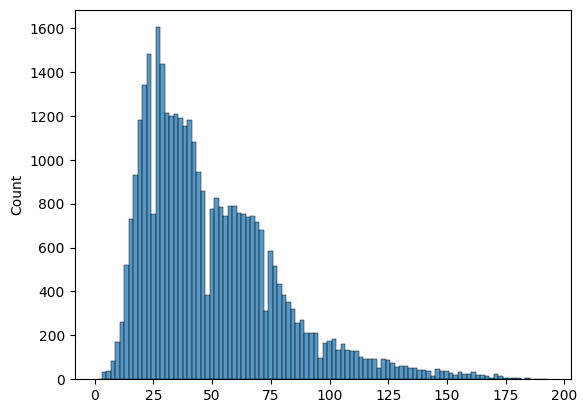

In [ ]:
# %% visualize the distribution of word counts in overviews:

sns.histplot(description_len, bins=100)
# 👀 Most overviews fall below 100 words.

In [ ]:
# %% embedding func to be used for encoding text data into vectors:

embedding_fn = SentenceTransformerEmbeddingFunction()

/Users/qingying/Desktop/side_projects/Remind-Me-a-Movie/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# %%

# # create a client object to connect to and interact with a Chroma database:
# chroma_db = chromadb.Client()

# create a client object to interact with a Chroma database named 'db':
chroma_db = chromadb.PersistentClient("db")  # create a local chroma db called 'db'

chroma_db.list_collections()  # list the tables in `chroma_db`
# [], no tables as we just started

[]

In [ ]:
# %% create (if the collection does not exist) or retrieve (if the collection already exists) the collection (table) called "movies":

chroma_collection = chroma_db.get_or_create_collection(
    "movies",
    embedding_function=embedding_fn,  # for encoding text data into vectors
)

chroma_db.list_collections()  # [Collection(name=movies)]

[Collection(name=movies)]

In [ ]:
# %% convert the vals in the specified cols to str & store them in python lists:

ids = df_movies_filt["id"].astype(str).tolist()  # int64 -> str
# print(ids)  # [ '615656', '758323', ... ]
documents = df_movies_filt["overview"].tolist()  # pandas series -> python list
titles = df_movies_filt["title"].tolist()
metadatas = [{"title": title} for title in titles]
# print(
#     metadatas[:5]
# )  # [ {'title': 'Meg 2: The Trench'}, {'title': "The Pope's Exorcist"}, ... ]

In [ ]:
# %% add data to the movies collection in the ChromaDB database in batches:

batch_size = 5000
for i in range(0, len(ids), batch_size):
    print(i)  # i = 0, 5000, 10000, ...
    chroma_collection.add(
        ids=ids[i : i + batch_size],
        documents=documents[i : i + batch_size],
        metadatas=metadatas[i : i + batch_size],
    )

0
5000
10000
15000
20000
25000
30000
35000


In [ ]:
# %% retrieve the IDs of all documents stored within the chroma_collection collection in the ChromaDB database

print(chroma_collection.get()["ids"])  # ['100', '10000', '10001', ...]
print(len(chroma_collection.get()["ids"]))  # 36976

['100', '10000', '10001', '100017', '10002', '100024', '10003', '10004', '100042', '100046', '10005', '100053', '10007', '10008', '100089', '10009', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '100183', '10019', '100192', '10020', '10021', '10022', '10023', '10024', '100241', '100246', '10025', '10027', '100271', '10028', '10029', '10030', '10032', '10033', '10034', '10035', '10036', '10037', '10040', '100402', '10042', '10044', '10045', '10046', '10047', '10048', '10049', '100493', '10050', '10051', '10052', '100529', '10053', '10054', '100542', '100544', '10056', '10057', '10060', '10061', '10063', '10064', '10065', '10066', '100669', '10067', '10068', '100683', '10069', '100697', '10070', '10071', '10072', '10073', '10074', '10075', '10077', '10078', '10081', '100812', '10083', '100830', '10085', '10086', '10087', '10089', '100898', '10090', '10092', '10093', '10094', '10096', '10098', '101', '10100', '10102', '10103', '10104', '10105', '10107', '10108', 

In [ ]:
# %% get title by description:

def get_title_by_description(query_text: str):
    n_results = 3
    res = chroma_collection.query(query_texts=[query_text], n_results=n_results)
    # print("👀", res)
    """
    {'ids': [['320288', '127585', '121133']], 'distances': [[0.8340994119644165, 0.8993083238601685, 0.902590811252594]], 'metadatas': [[{'title': 'Dark Phoenix'}, {'title': 'X-Men: Days of Future Past'}, {'title': 'X-Men: The Legend of Wolverine'}]], 'embeddings': None, 'documents': [["The X-Men face their most formidable and powerful foe when one of their own Jean Grey starts to spiral out of control. During a rescue mission in outer space Jean is nearly killed when she's hit by a mysterious cosmic force. Once she returns home this force not only makes her infinitely more powerful but far more unstable. The X-Men must now band together to save her soul and battle aliens that want to use Grey's new abilities to rule the galaxy.", 'The ultimate X-Men ensemble fights a war for the survival of the species across two time periods as they join forces with their younger selves in an epic battle that must change the past – to save our future.', "The most popular Super Hero Team in history is ready for action in a spectacular series of thrilling adventures. When a familiar face from Wolverine's former life resurfaces he must wage a war he never intended. Ultimately the X-Men must join forces with Magneto in a fight to save all mutants from annihilation.  Discover the truth of Wolverine's secret past and watch his decisive battle as he is forced to make a choice that will forever affect the fate of the X-Men."]], 'uris': None, 'data': None}
    """
    for i in range(n_results):
        # NOTE: metadatas = [{"title": title} for title in titles]
        pprint(f"Title: {res['metadatas'][0][i]['title']}")
        # NOTE: documents = df_movies_filt["overview"].tolist()
        pprint(f"Description: {res['documents'][0][i]}")
        pprint("---------------------------------")

In [ ]:
# %% call the func:

get_title_by_description(query_text="X, superheros")

'Title: Dark Phoenix'
('Description: The X-Men face their most formidable and powerful foe when one '
 'of their own Jean Grey starts to spiral out of control. During a rescue '
 "mission in outer space Jean is nearly killed when she's hit by a mysterious "
 'cosmic force. Once she returns home this force not only makes her infinitely '
 'more powerful but far more unstable. The X-Men must now band together to '
 "save her soul and battle aliens that want to use Grey's new abilities to "
 'rule the galaxy.')
'---------------------------------'
'Title: X-Men: Days of Future Past'
('Description: The ultimate X-Men ensemble fights a war for the survival of '
 'the species across two time periods as they join forces with their younger '
 'selves in an epic battle that must change the past – to save our future.')
'---------------------------------'
'Title: X-Men: The Legend of Wolverine'
('Description: The most popular Super Hero Team in history is ready for action '
 'in a spectacular seri